# Climate in Hawaii

### Reflect Tables

* Measurement
* Stations

### Exploratory Climate Analysis

 1. Precipitation Analysis (for last 12 months)

 2. Station Analysis


$\star$ The Climate App API: /api/v1.0/precipitation, /api/v1.0/stations, and more

### Bonus Challenges

 1. Temperature Analysis 1 : t-test

 2. Temperature Analysis 2 : Temperatures during trip dates

 3. Daily Rainfall Average


## Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Stations = Base.classes.station

In [9]:
# The columns in measurment table
columns = inspect(engine).get_columns('measurement')
for col in columns:
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# The columns in station table
columns = inspect(engine).get_columns('station')
for col in columns:
    print(col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Exploratory Climate Analysis

In [12]:
import pandas as pd
import numpy as np
from scipy import stats

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')

import matplotlib.pyplot as plt

import datetime as dt

### 1. Precipitation Analysis (for last 12 months)

* The latest date in measurement table

In [107]:
# queries to retrieve the earliest and latest dates in measurement table
last_dt = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
session.close()
print(f"The latest date is {last_dt[0]}")

The latest date is 2017-08-23


* The precipitation data for the last 12 months

In [108]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.datetime.strptime(last_dt[0], "%Y-%m-%d") - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
# which is ordered by date
prec_data = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= year_ago).\
            order_by(Measurement.date).all()
session.close()
# Save the query results as a Pandas DataFrame
# and set the index to the date column
prec_df = pd.DataFrame(prec_data).set_index('date')

# Drop the rows with NaN
prec_df = prec_df.dropna()

* Plot the precipitation data

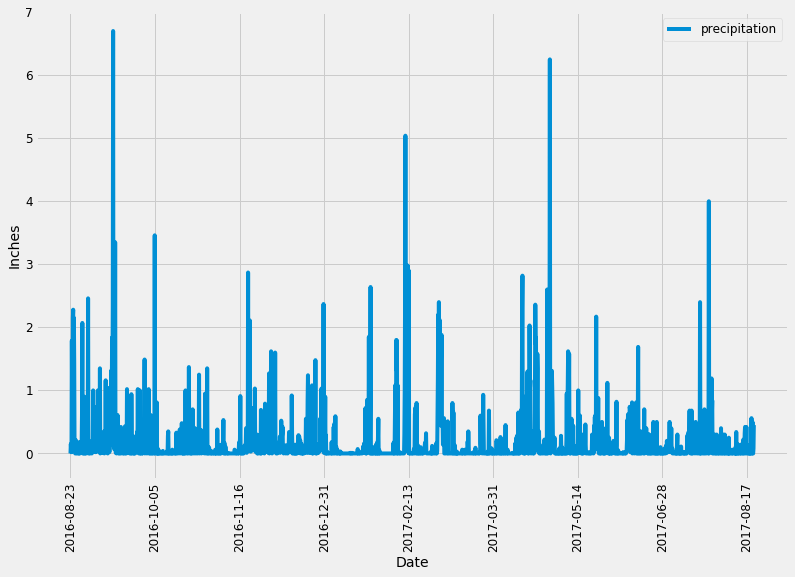

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = prec_df.plot(yticks=np.arange(8), ylim=[-0.4, 7], 
                  figsize=(12,8), fontsize=12, rot=90)
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Inches", fontsize=14)
ax.legend(["precipitation"], loc='upper right', fontsize=12)

# Save the image
ax.get_figure().savefig("images/precipitation.png", bbox_inches='tight')

* The summary statistics for the precipitation data

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
#prec_df.agg(['min', 'max', 'mean', 'median', 'std', 'sem'])
prec_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### 2. Station Analysis

* Most active station

In [109]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(
                        func.count(Measurement.station.distinct())).\
                        filter(Stations.station==Measurement.station).scalar()
session.close()
print(f"There are {total_stations} stations in measurement dataset")

There are 9 stations in measurement dataset


In [110]:
# Query to retrieve the station id, station, the number of observations
stations_cnt = session.query(
                        Stations.id,
                        Measurement.station,
                        func.count(Measurement.id)).\
        filter(Stations.station == Measurement.station).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.date).desc()).all()
session.close()

# List the stations and the counts in descending order.
pd.DataFrame({
    "Station Id" :  [stations_cnt[i][0] for i in range(total_stations)],
    "Station" : [stations_cnt[i][1] for i in range(total_stations)],
    "Obs. Count" : [stations_cnt[i][2] for i in range(total_stations)]
})

,Station Id,Station,Obs. Count
0,7,USC00519281,2772
1,1,USC00519397,2724
2,2,USC00513117,2709
3,6,USC00519523,2669
4,9,USC00516128,2612
5,3,USC00514830,2202
6,8,USC00511918,1979
7,4,USC00517948,1372
8,5,USC00518838,511


* Using the 'station' from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature of the most active station.

In [111]:
# Set the most active station
station_query = 'USC00519281'

# Query to retrieve the min temp, max temp, and avg temp for the station
result = session.query(func.min(Measurement.tobs),
                       func.max(Measurement.tobs),
                       func.avg(Measurement.tobs)).\
                group_by(Measurement.station).\
                filter(Measurement.station == station_query).all()
session.close()

# Print the results
print(f"The most active station is {station_query}")
print(f"Its lowest temperature is {result[0][0]}")
print(f"Its highest temperature is {result[0][1]}")
print(f"Its average temperature is {result[0][2]:.2f}")

The most active station is USC00519281
Its lowest temperature is 54.0
Its highest temperature is 85.0
Its average temperature is 71.66


* Query to retrieve the last 12 months of temperature observation data (TOBS) for the most active station='USC00519281'

* Plot the results as a histogram

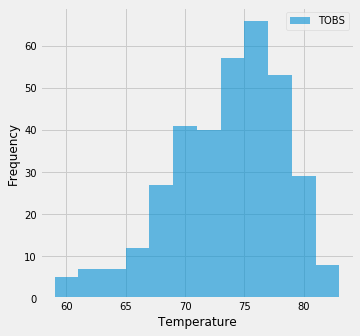

In [112]:
# Query the last 12 months of temperature observation data for this station
tobs_data = session.query(Measurement.date, Measurement.tobs).\
            filter(Measurement.date > year_ago).\
            filter(Measurement.station == station_query).\
            order_by(Measurement.date).all()
session.close()

# Save the query results as a Pandas DataFrame
# and set the index to the date column
tobs_df = pd.DataFrame(tobs_data).set_index('date')

# Drop the rows with NaN
tobs_df = tobs_df.dropna()

# Convert the 'date' object to datetime type
tobs_df.index = pd.to_datetime(tobs_df.index)

# Plot the results as a histogram
ax = tobs_df.plot.hist(bins=12, alpha=0.6, figsize=(5,5), fontsize=10)
ax.set_xlabel("Temperature", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.legend(["TOBS"], fontsize=10)

# Save the image
ax.get_figure().savefig("images/station-histogram.png", bbox_inches='tight')

## Bonus Challenge Assignment

### 1. Temperature Analysis 1 : t-test

Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

- Null hypothesis: The temperature is similar in June and Decemenber.

- The samples are independent: The retrieved data has different size. That is, the samples of June and December are independently collected.

Use the <em>unpaired</em> t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [21]:
def month_temps(month):
    """
    Args:
        month(string): a month in the format %m

    Returns:
        np array of the temperatures of the month of all years
        mean of temperatures of the month of all years
        variance of temperatures of the month of all years
        number of results
    """
    result = session.query(Measurement.tobs).\
            filter(func.strftime("%m", Measurement.date) == month).all()
    session.close()
    
    np_result = np.array([t[0] for t in result])    
    return np_result

# Collect the temperature data for the twon months oll all years
m = {"June" : '06', "December": '12'}
result1 = month_temps(list(m.values())[0])
result2 = month_temps(list(m.values())[1])

# Calculate the t-value, p-value
tval, pval = stats.ttest_ind(result1, result2)
print(f"T-value : {tval}")
print(f"P-value : {pval}")

# Print the summary of the samples
pd.DataFrame(
    [[np.mean(result1), np.var(result1), len(result1)],
     [np.mean(result2), np.var(result2), len(result2)]],
    columns=["avg", "var", "size"],
    index = m.keys())

T-value : 31.60372399000329
P-value : 3.9025129038616655e-191


,avg,var,size
June,74.944118,10.604524,1700
December,71.041529,14.022666,1517


----> The T-value is somewhat small, which leads us to accept the Null-hypothesis- there is no meaningful difference between the temperature in June and December.

### 2. Temperature Analysis 2 : Temperatures during trip dates

* The min, avg, and max temperatures for your trip using the matching dates from the previous year

* Bar chart for the min, avg, and max temperature from your previous query

In [25]:
# Set the start and end date of the trip
trip_start = dt.datetime(2018,1,1)
trip_end = dt.datetime(2018,1,7)

In [26]:
# This function called `calc_temps` will accept start date and end date
# in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures
# for that range of dates
def calc_temps(start_date, end_date):
    """ TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    result = session.query(
            func.min(Measurement.tobs), 
            func.avg(Measurement.tobs), 
            func.max(Measurement.tobs)).\
            filter(Measurement.date >= start_date).\
            filter(Measurement.date <= end_date).all()
    session.close()
    return result

In [53]:
# Set the previous year's maching dates
start_date = (trip_start-dt.timedelta(days=366)).strftime('%Y-%m-%d')
end_date = (trip_end-dt.timedelta(days=366)).strftime('%Y-%m-%d')

# Calculate the tmin, tavg, and tmax for your trip 
# using the previous year's data for those same dates.
[(tmin, tavg, tmax)] = calc_temps(start_date, end_date)

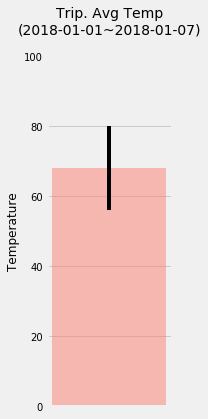

In [106]:
# Plot the results from your previous query as a bar chart. 
# bar height = average temperature
plt.figure(figsize=(2,6))
plt.title(f"Trip. Avg Temp\n({trip_start.strftime('%Y-%m-%d')}~{trip_end.strftime('%Y-%m-%d')})\n", fontsize=14)
plt.bar(x=1, height=tavg, yerr=tmax-tmin, color='salmon', alpha=0.5)
plt.xticks([])
plt.ylim([0,100])
plt.yticks(fontsize=10)
plt.ylabel("Temperature", fontsize=12)

# Save the image
plt.savefig("images/temperature.png", bbox_inches='tight')
plt.show()

### 3. Daily Rainfall Average

* The rainfall per weather station

  Calculate the total amount of rainfall per weather station
 for your trip dates using the previous year's matching dates.

In [113]:
# Set the previous year's maching dates
start_date = (trip_start-dt.timedelta(days=366)).strftime('%Y-%m-%d')
end_date = (trip_end-dt.timedelta(days=366)).strftime('%Y-%m-%d')

# Query to retrieve the average rainfall of each station
results=session.query(Measurement.station,
                         Stations.name, 
                         Stations.latitude, Stations.longitude,
                         Stations.elevation,
                         func.avg(Measurement.prcp)).\
            group_by(Measurement.station).\
            filter(Measurement.station == Stations.station).\
            filter(Measurement.date >= start_date).\
            filter(Measurement.date <= end_date).all()
session.close()

# Sort this in descending order by precipitation amount
# and list the station, name, latitude, longitude, and elevation
pd.DataFrame(results, 
             columns=["Station", "Name", "Lat.", "Lng.", "Elev.", "PRCP"]).\
             sort_values(by=["PRCP"], ascending=False, ignore_index=True)

,Station,Name,Lat.,Lng.,Elev.,PRCP
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.214286
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.203333
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.137143
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.130000
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.064286
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.001429


* The daily normals. Normals are the averages for the min, avg, and max temperatures.

  Calculate the daily normals for your trip


In [60]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    result = session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    session.close()

In [97]:
# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start=trip_start, end=trip_end)

# Loop through the list of %m-%d strings and calculate the normals for each date
# push each tuple of calculations into a list called `normals`
normals = []
for date in trip_dates:
    # Stip off the year and save a list of %m-%d strings
    # and call the function 'daily_normals'
    result = daily_normals(date.strftime("%m-%d"))
    normals.append(result[0])

# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, 
                          columns=["tmin", "tavg", "tmax"],
                          index=trip_dates.date)
normals_df

,tmin,tavg,tmax
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


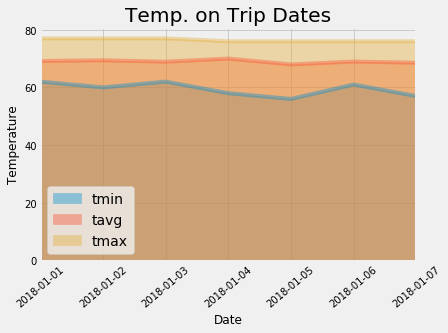

In [102]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot.area(stacked=False, alpha=0.4, rot=40, fontsize=10)
ax.set_title("Temp. on Trip Dates")
ax.set_xlabel("Date", fontsize=12)
ax.set_xlim([trip_start.date(), trip_end.date()])
ax.set_ylabel("Temperature", fontsize=12)
# Save the image
ax.get_figure().savefig("images/daily-normals.png", bbox_inches='tight')